In [58]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import urllib.request as request
import matplotlib.pyplot as plt

In [59]:
# Read recipe inputs
iris = dataiku.Dataset("iris")
iris_df = iris.get_dataframe()

In [60]:
# Compute recipe outputs from inputs
# TODO: Replace this part by your actual code that computes the output, as a Pandas dataframe
# NB: DSS also supports other kinds of APIs for reading and writing data. Please see doc.
iris_ml_df = iris_df # For this sample code, simply copy input to output

In [61]:
# Split data into y and X
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
yy = iris_ml_df['species']
XX = iris_ml_df[feature_names]

In [62]:
# Encode target values into binary ('one-hot' style) representation
yyy = pd.get_dummies(yy)

In [63]:
# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(XX, yyy, random_state = 1)

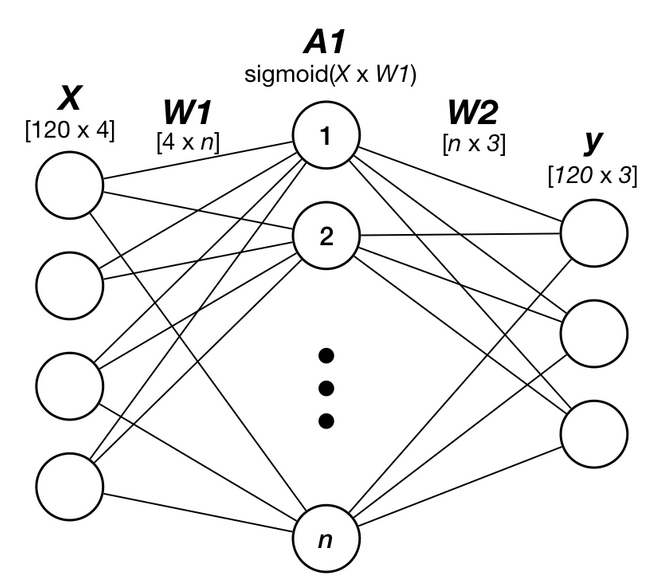

The code below defines a function in which we create the model, define a loss function that needs to be minimized, and run a session with 2000 iterations to learn the optimal weights W_1 and W_2. As mentioned earlier, the input and output matrices are fed to tf.placeholder tensors and the weights are represented as variables because their values change in each iteration. The loss function is defined as the mean squared error between our prediction y_est and the actual species type y, and the activation function we use is sigmoid. The create_train_model function returns the learned weights and prints out the final value of the loss function.

In [81]:
# Create and train a tensorflow model of a neural network
def create_train_model(hidden_nodes, num_iters):

    # Reset the graph
    tf.reset_default_graph()

    # Placeholders for input and output data
    X = tf.placeholder(shape=(112, 4), dtype=tf.float64, name='X')
    y = tf.placeholder(shape=(112, 3), dtype=tf.float64, name='y')

    # Variables for two group of weights between the three layers of the network
    W1 = tf.Variable(np.random.rand(4, hidden_nodes), dtype=tf.float64)
    W2 = tf.Variable(np.random.rand(hidden_nodes, 3), dtype=tf.float64)

    # Create the neural net graph
    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))

    # Define a loss function
    deltas = tf.square(y_est - y)
    loss = tf.reduce_sum(deltas)

    # Define a train operation to minimize the loss
    optimizer = tf.train.GradientDescentOptimizer(0.005)
    train = optimizer.minimize(loss)

    # Initialize variables and run session
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    # Go through num_iters iterations
    for i in range(num_iters):
        sess.run(train, feed_dict={X: X_train, y: y_train})
        loss_plot[hidden_nodes].append(sess.run(loss, feed_dict={X: X_train.as_matrix(), y: y_train.as_matrix()}))
        weights1 = sess.run(W1)
        weights2 = sess.run(W2)

    print("loss (hidden nodes: %d, iterations: %d): %.2f" % (hidden_nodes, num_iters, loss_plot[hidden_nodes][-1]))
    sess.close()
    return weights1, weights2

loss (hidden nodes: 5, iterations: 2000): 5.43
loss (hidden nodes: 10, iterations: 2000): 31.66
loss (hidden nodes: 20, iterations: 2000): 9.44


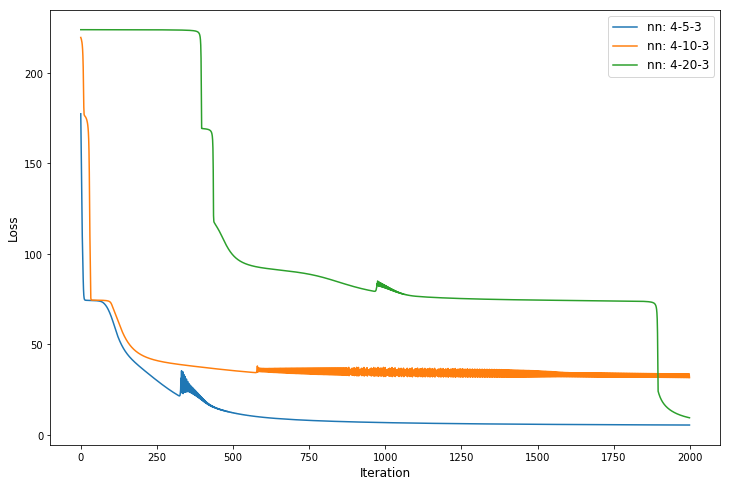

In [65]:
# Run the training for 3 different network architectures: (4-5-3) (4-10-3) (4-20-3)

# Plot the loss function over iterations
num_hidden_nodes = [5, 10, 20]
loss_plot = {5: [], 10: [], 20: []}
weights1 = {5: None, 10: None, 20: None}
weights2 = {5: None, 10: None, 20: None}
num_iters = 2000

plt.figure(figsize=(12,8))
for hidden_nodes in num_hidden_nodes:
    weights1[hidden_nodes], weights2[hidden_nodes] = create_train_model(hidden_nodes, num_iters)
    plt.plot(range(num_iters), loss_plot[hidden_nodes], label="nn: 4-%d-3" % hidden_nodes)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

In [75]:
# Evaluate models on the test set
X = tf.placeholder(shape=(38, 4), dtype=tf.float64, name='X')
y = tf.placeholder(shape=(38, 3), dtype=tf.float64, name='y')

for hidden_nodes in num_hidden_nodes:

    # Forward propagation
    W1 = tf.Variable(weights1[hidden_nodes])
    W2 = tf.Variable(weights2[hidden_nodes])
    A1 = tf.sigmoid(tf.matmul(X, W1))
    y_est = tf.sigmoid(tf.matmul(A1, W2))

    # Calculate the predicted outputs
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        y_est_np = sess.run(y_est, feed_dict={X: X_test, y: y_test})

    # Calculate the prediction accuracy
    correct = [estimate.argmax(axis=0) == target.argmax(axis=0) 
               for estimate, target in zip(y_est_np, y_test.as_matrix())]
    accuracy = 100 * sum(correct) / len(correct)
    print('Network architecture 4-%d-3, accuracy: %.2f%%' % (hidden_nodes, accuracy))

5
Network architecture 4-5-3, accuracy: 97.00%
10
Network architecture 4-10-3, accuracy: 92.00%
20
Network architecture 4-20-3, accuracy: 97.00%


In [76]:
# Write recipe outputs
iris_ml = dataiku.Dataset("iris_ml")
iris_ml.write_with_schema(iris_ml_df)

150 rows successfully written (4dqBz4aTjm)


In [103]:
target

array([1, 0, 0], dtype=uint8)

In [96]:
zip(y_est_np, y_test.as_matrix())

[(array([ 0.9765656 ,  0.0348129 ,  0.04807143]),
  array([1, 0, 0], dtype=uint8)),
 (array([ 0.10421768,  0.84726332,  0.16331341]),
  array([0, 1, 0], dtype=uint8)),
 (array([ 0.03557074,  0.93623275,  0.21649528]),
  array([0, 1, 0], dtype=uint8)),
 (array([ 0.97631071,  0.03489331,  0.04847982]),
  array([1, 0, 0], dtype=uint8)),
 (array([ 0.01266894,  0.37585688,  0.59550794]),
  array([0, 0, 1], dtype=uint8)),
 (array([ 0.02612749,  0.87427904,  0.29946241]),
  array([0, 1, 0], dtype=uint8)),
 (array([ 0.01227135,  0.26473689,  0.63125077]),
  array([0, 0, 1], dtype=uint8)),
 (array([ 0.97365941,  0.03841251,  0.04985794]),
  array([1, 0, 0], dtype=uint8)),
 (array([ 0.97248632,  0.04075398,  0.04999835]),
  array([1, 0, 0], dtype=uint8)),
 (array([ 0.00854923,  0.07389336,  0.77382683]),
  array([0, 0, 1], dtype=uint8)),
 (array([ 0.02461601,  0.84856167,  0.32268533]),
  array([0, 1, 0], dtype=uint8)),
 (array([ 0.97549557,  0.03601303,  0.04893593]),
  array([1, 0, 0], dtype=u

In [110]:
y_est_np.argmax(axis=1)

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1,
       0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0])

In [108]:
np.argmax(y_test.as_matrix(),axis=1)

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0])

In [114]:
np.argmax(y_est_np,axis=1),np.argmax(y_test.as_matrix(),axis=1)

(array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1,
        0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0]),
 array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0]))

In [115]:
y_est_np

array([[ 0.9765656 ,  0.0348129 ,  0.04807143],
       [ 0.10421768,  0.84726332,  0.16331341],
       [ 0.03557074,  0.93623275,  0.21649528],
       [ 0.97631071,  0.03489331,  0.04847982],
       [ 0.01266894,  0.37585688,  0.59550794],
       [ 0.02612749,  0.87427904,  0.29946241],
       [ 0.01227135,  0.26473689,  0.63125077],
       [ 0.97365941,  0.03841251,  0.04985794],
       [ 0.97248632,  0.04075398,  0.04999835],
       [ 0.00854923,  0.07389336,  0.77382683],
       [ 0.02461601,  0.84856167,  0.32268533],
       [ 0.97549557,  0.03601303,  0.04893593],
       [ 0.0083911 ,  0.08086312,  0.77168745],
       [ 0.03274821,  0.92478809,  0.23576275],
       [ 0.02235667,  0.81800291,  0.35202851],
       [ 0.97394712,  0.03860962,  0.04947387],
       [ 0.03347511,  0.92603427,  0.23399706],
       [ 0.01722508,  0.52960085,  0.48966027],
       [ 0.97484587,  0.0374324 ,  0.04891419],
       [ 0.97515052,  0.0372963 ,  0.04859735],
       [ 0.018145  ,  0.67405345,  0.439